In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

# Loading of all datasets, preprocessing and combining them to a single one

In [19]:
#Stocks
sp500 = pd.read_csv('^GSPC.csv',parse_dates = ['Date'], index_col='Date')
apple = pd.read_csv('AAPL.csv',parse_dates = ['Date'], index_col='Date')
mic = pd.read_csv('MSFT.csv',parse_dates = ['Date'], index_col='Date')
goog =  pd.read_csv('GOOG.csv',parse_dates = ['Date'], index_col='Date')
amz =  pd.read_csv('AMZN.csv',parse_dates = ['Date'], index_col='Date')

In [20]:
comb = pd.DataFrame(index=apple.index)
comb['apple'] = apple.Close
comb['sp500'] = sp500.Close
comb['mic'] = mic.Close
comb['goog'] = goog.Close
comb['amz'] = amz.Close
comb['volume'] = apple.Volume

In [21]:
#Oil
oil = pd.read_csv('oil.csv', parse_dates=True, index_col='observation_date')
oil.drop(['realtime_end_date', 'realtime_start_date'],axis=1,inplace=True)
oil.fillna(method = 'bfill',inplace=True)
oil.rename_axis(index={'observation_date': 'date'}, inplace=True)
oil.columns = ['price']
comb = comb.join(oil.price, how='left')

In [22]:
#Covid 
covid = pd.read_csv('owid-covid-data.csv', parse_dates=['date'], index_col=['date'])
covid.sort_index().fillna(method='backfill', inplace=True)
where = 'CHN'
att = 'iso_code'
total = []
for x in covid[covid[att] == where].sort_index().index.unique():
    total.append(covid[covid[att] == where].loc[x]['new_cases_smoothed'].sum())
chn = pd.DataFrame(total, index=covid[covid[att] == where].sort_index().index.unique(), columns = ['new_cases_smoothed'])
comb = comb.join(chn.new_cases_smoothed, how='left')
comb.new_cases_smoothed.fillna(0,inplace=True)

In [23]:
#EPS
eps = pd.read_csv('eps.csv')
eps.drop(['Announcement Date'],axis=1,inplace=True)
eps.columns = ['date','estimate','actual']
eps.date = pd.to_datetime(eps.date)
eps.set_index('date',inplace=True)

import re
for i in range(len(eps.estimate)): 
    eps.estimate[i] = re.sub("[$]", "", eps.estimate[i])
    eps.actual[i] = re.sub("[$]", "", eps.actual[i])
eps.estimate = eps.estimate.astype(str).astype(float)
eps.actual = eps.actual.astype(str).astype(float)
eps['dif'] = eps.actual - eps.estimate
eps.sort_index(inplace=True)
eps = eps.loc['2016-12-16':'2020-09-30']
eps = _resample(eps)
comb = comb.join(eps.dif, how='left')

In [24]:
scaler = StandardScaler()
scaled = scaler.fit_transform(comb)
df = pd.DataFrame(scaled, index=comb.index, columns = comb.columns)

In [25]:
#Events
time = ['05/06/2017',
'12/09/2017',
'27/03/2018',
'04/06/2018',
'12/09/2018',
'30/10/2018',
'25/03/2019',
'03/06/2019',
'10/09/2019',
'02/12/2019',
'22/06/2020',
'15/09/2020',
'13/10/2020',
'10/10/2020']

t = pd.DataFrame(time,columns=['date'])
t['date']= pd.to_datetime(t.date)
t.set_index('date',inplace=True)
t['event'] = np.ones(14)
df = df.join(t.event, how='left')
df.event.fillna(0,inplace=True)

# Original Data

<Figure size 1152x576 with 0 Axes>

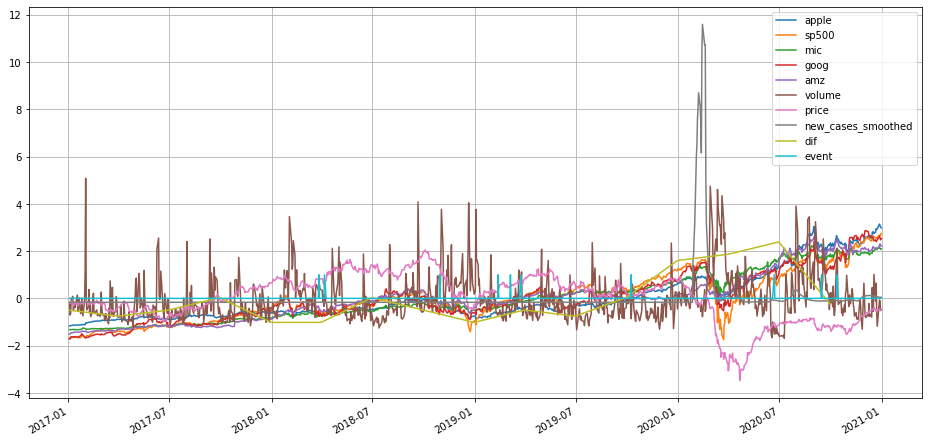

In [33]:
plt.figure(figsize=(16,8))
df.plot(figsize=(16,8))
plt.grid(True)

In [100]:
df.to_csv('complete.csv')

# Rolling Avg Data

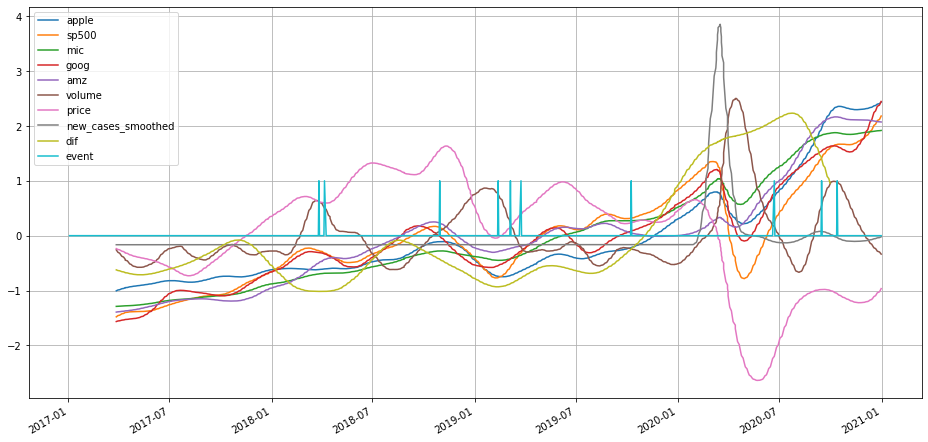

In [38]:
dfm = df[df.columns[:-1]].rolling(window=30).mean()
dfm['event'] = df.event
dfm.plot(figsize=(16,8))
plt.grid(True)

In [28]:
dfm.to_csv('complete_mean_30.csv')

In [27]:
def _resample(df):

    # Upsample in order to have data for every minute.
    df_res = df.resample('1T')

    # Interpolate through time
    df_res = df_res.interpolate(method='time')

    # Downsample to a 1-hour basis (60 minutes).
    df_res = df_res.resample('1D')

    df_res = df_res.interpolate()

    # We can remove all empty rows or leave like this for missing values analysis?
    #df_res = df_res.dropna(how='all')

    return df_res